In [1]:
#ATTENTION! CYLINDER_ALL.mat is not added to DATA/FLUIDS folder due the github upload file size restrictions. 
#DONT run this notebook without putting data in the corresponding folders

import torch
import torch.nn as nn # torch should be imported first, otherwise kernel dies
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/Users/Saizt/opt/anaconda3/envs/UH/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exercise 6.3 (i)

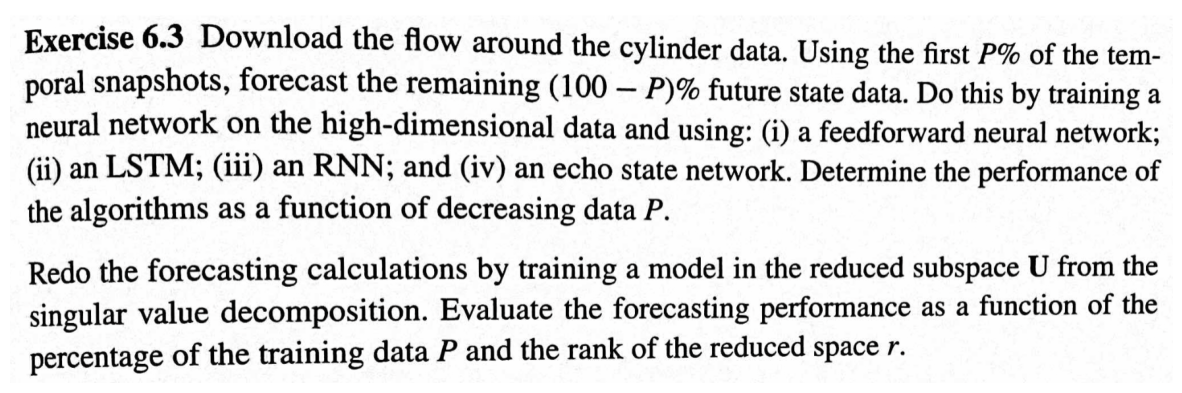

In [2]:
# Assignment due Tuesday 11/15: Exercise 5.1. The example code that comes with the book will be useful.
plt.figure(figsize=(15, 12))
plt.imshow(plt.imread('./ex6.3.png'))
plt.axis('off');

In [3]:
mat_contents = scipy.io.loadmat('../DATA/FLUIDS/CYLINDER_ALL.mat')
VORTALL = mat_contents['VORTALL']

M, N = *mat_contents['m'], *mat_contents['n']

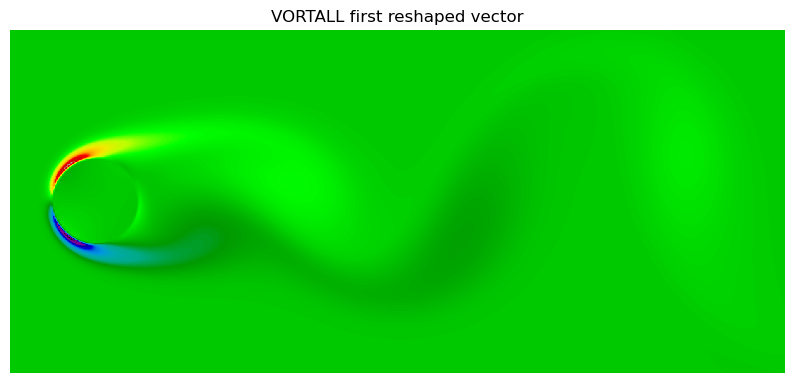

In [4]:
plt.figure(figsize=(10, 5))

plt.imshow(VORTALL[:,0].reshape(*N,*M).T, cmap='nipy_spectral')
plt.title('VORTALL first reshaped vector')
plt.axis('off');

In [5]:
P = 0.8
TRAIN = VORTALL[:, :int(VORTALL.shape[1]*P)]
TEST = VORTALL[:, int(VORTALL.shape[1]*P)-1:]

torch.manual_seed(0)
LOADER = torch.utils.data.DataLoader(TRAIN.T, batch_size=2, shuffle=False)

In [6]:
class FeedForwardNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.FFNN = nn.Sequential(
                                nn.Linear(self.input_dim, self.input_dim),
                                nn.ReLU(),
                                # nn.Dropout(0.3),
                                #nn.Linear(input_dim, input_dim),
                                #nn.LeakyReLU(),
                                # nn.Dropout(0.2),
                                nn.Linear(self.input_dim, self.input_dim) # nn.Sigmoid()
        )

    def forward(self, x):
        return self.FFNN(x)

    
class Model(FeedForwardNN):
    def __init__(self, shapes, learning_rate=1e-4, print_every=5):
        self.input_dim = shapes[0]
        self.num_chunks = shapes[1]
        self.learning_rate = learning_rate
        super().__init__()
        self.optimizer = torch.optim.Adam(self.FFNN.parameters(), lr=self.learning_rate)
        self.chunk_pred = []
        self.loss = []
        self.validation = []
        self.print_every = print_every
    
    def chunks(self, max_layer_input, divider):
        return [(i*max_layer_input//divider, (i+1)*max_layer_input//divider) for i in range(divider)]
    
    def train(self, data_loader, epochs):
        for epoch in tqdm(range(epochs)):
            for batch_idx, (train, test) in enumerate(data_loader):
                for (start, end) in self.chunks(self.input_dim*self.num_chunks, self.num_chunks):
                    train_chunk, test_chunk = train[start:end].float(), test[start:end].float()
                    net_real = self.FFNN(train_chunk)
                    self.chunk_pred.append(net_real)

                    self.optimizer.zero_grad()
                    loss = nn.MSELoss()(net_real, test_chunk)
                    loss.backward()
                    self.optimizer.step()

                    
                self.loss.append(nn.MSELoss()(torch.ravel(torch.stack(self.chunk_pred)), test).data.item())
                self.chunk_pred = []
                
                ### Print training statistics
                if batch_idx % self.print_every==0:
                    print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(LOADER)}] Loss: {self.loss[-1]}")
                    
    def predict(self, data_loader):
        self.chunk_pred = []
        for pair_idx, (X_test, Y_test) in enumerate(data_loader):
            for (start, end) in self.chunks(self.input_dim*self.num_chunks, self.num_chunks):
                X_test_chunk, Y_test_chunk = X_test[start:end].float(), Y_test[start:end].float()
                net_real = self.FFNN(X_test_chunk)
                self.chunk_pred.append(net_real)

            self.validation.append(nn.MSELoss()(torch.ravel(torch.stack(self.chunk_pred)), Y_test).data.item())
            self.chunk_pred = []
                
    def plot(self):
        f, ax = plt.subplots(1, 2, figsize=(10, 5))
        
        ax[0].plot(self.loss, c='black')
        ax[0].set_title('Train MSE')
        ax[0].set_xlabel('Epoch * Batch')
        ax[1].plot(self.validation, c='black')
        ax[1].set_title('Test MSE')
        ax[1].set_xlabel('Pair index');

In [7]:
torch.manual_seed(0)
net = Model(shapes=(int(*N),int(*M)), learning_rate=1e-4, print_every=10)
net.train(LOADER, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50] Batch [1/60] Loss: 1.2147476492632596
Epoch [1/50] Batch [11/60] Loss: 0.10740524549262553
Epoch [1/50] Batch [21/60] Loss: 0.04698790314198538
Epoch [1/50] Batch [31/60] Loss: 0.04412923747327436
Epoch [1/50] Batch [41/60] Loss: 0.0357723522446644
Epoch [1/50] Batch [51/60] Loss: 0.03797920538677161


  2%|▏         | 1/50 [00:43<35:41, 43.71s/it]

Epoch [2/50] Batch [1/60] Loss: 0.04067498913512888


  2%|▏         | 1/50 [00:49<40:45, 49.91s/it]


KeyboardInterrupt: 

In [8]:
torch.manual_seed(0)
VALIDATION = torch.utils.data.DataLoader(TEST.T, batch_size=2, shuffle=False)
net.predict(VALIDATION)

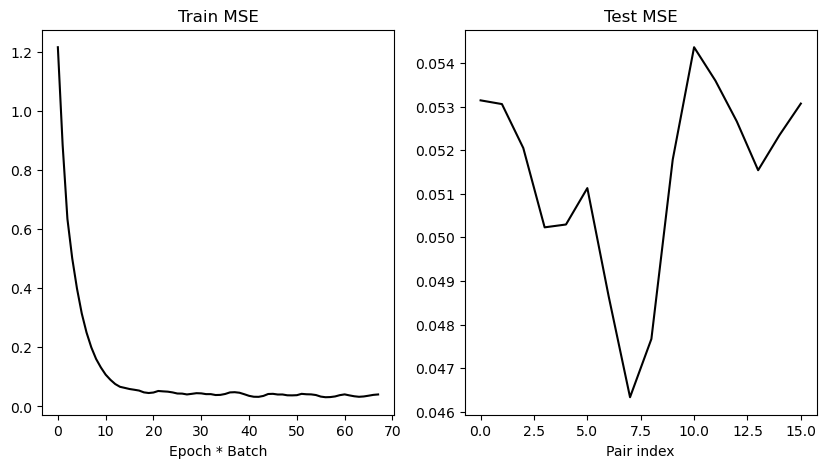

In [9]:
net.plot()

For different P, I have to retrain and predict several times with changing train/test data. It consumes a lot of time.

I will stop at showing results for just a fixed P.

In [10]:
U, S, VT = np.linalg.svd(VORTALL, full_matrices=False)

In [13]:
P = 0.8
TRAIN = U[:, :int(U.shape[1]*P)]
TEST = U[:, int(U.shape[1]*P)-1:]

torch.manual_seed(0)
LOADER = torch.utils.data.DataLoader(TRAIN.T, batch_size=2, shuffle=False)

In [14]:
torch.manual_seed(0)
net = Model(shapes=(int(*N),int(*M)), learning_rate=1e-4, print_every=10)
net.train(LOADER, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50] Batch [1/60] Loss: 0.00011191406825428391
Epoch [1/50] Batch [11/60] Loss: 1.2029200546896838e-05
Epoch [1/50] Batch [21/60] Loss: 1.1983887980184528e-05
Epoch [1/50] Batch [31/60] Loss: 1.2446953253354083e-05
Epoch [1/50] Batch [41/60] Loss: 1.2220372993864483e-05
Epoch [1/50] Batch [51/60] Loss: 1.2161759652680418e-05


  2%|▏         | 1/50 [00:37<30:59, 37.96s/it]

Epoch [2/50] Batch [1/60] Loss: 9.696231108512165e-06
Epoch [2/50] Batch [11/60] Loss: 1.1652467549450751e-05


  2%|▏         | 1/50 [00:47<39:03, 47.83s/it]


KeyboardInterrupt: 

In [15]:
torch.manual_seed(0)
VALIDATION = torch.utils.data.DataLoader(TEST.T, batch_size=2, shuffle=False)
net.predict(VALIDATION)

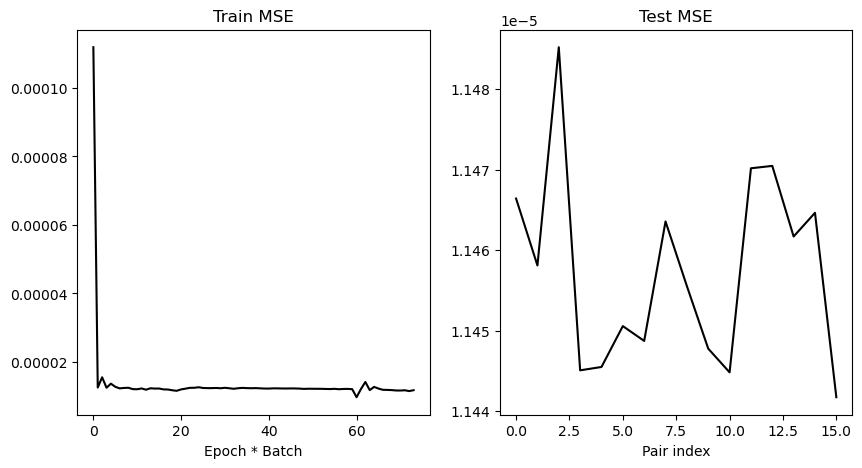

In [16]:
net.plot()

Due the same reason, I will stop at fixed P.

As we can notice, forecasting the next U-mode state perform much better than forecasting of the original data.

I guess acting in such way for S and VT matricies, we can reconstruct the real flow around cylinder even better.